In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers

In [77]:
plt.rcParams['figure.figsize'] = (15, 10)

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

## Erstelle aus `health-insurance.csv` einen DataFrame

In [78]:
insurance = pd.read_csv('./data/health-insurance.csv')
insurance = insurance.drop(columns=['ID', 'Region_Code', 'City_Code'])
insurance.isnull().sum()

Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

## Data Cleaning

* fehlende `Holding_Policy_Duration`/`Holding_Policy_Type`-Werte sind gleich viele, sollten also gleich behandelt werden
* betrachte die Ausprägungen von `Health Indicator`. Auch hier gibt es einige `NaN`s

In [79]:
insurance.head()

Accomodation_Type Reco_Insurance_Type  Upper_Age  Lower_Age Is_Spouse  \
0            Rented          Individual         36         36        No   
1             Owned               Joint         75         22        No   
2             Owned          Individual         32         32        No   
3             Owned               Joint         52         48        No   
4            Rented          Individual         44         44        No   

  Health Indicator Holding_Policy_Duration  Holding_Policy_Type  \
0               X1                     14+                  3.0   
1               X2                     NaN                  NaN   
2              NaN                     1.0                  1.0   
3               X1                     14+                  3.0   
4               X2                     3.0                  1.0   

   Reco_Policy_Cat  Reco_Policy_Premium  Response  
0               22              11628.0         0  
1               22              30510.0         0  
2               19               7450.0         1  
3               19              17780.0         0  
4               16              10404.0         0

In [80]:
insurance = pd.get_dummies(data=insurance, columns=["Accomodation_Type", "Reco_Insurance_Type"], drop_first=True)

In [81]:
insurance["Is_Spouse"] = insurance["Is_Spouse"].replace("No", 0).replace("Yes", 1)

In [82]:
insurance["Health Indicator"] = insurance["Health Indicator"].replace({"X1": 1, "X2": 2, "X3": 3, "X4": 4, "X5": 5, "X6": 6, "X7": 7, "X8": 8, "X9": 9})
insurance["Health Indicator"] = insurance["Health Indicator"].fillna(insurance["Health Indicator"].mean())

In [83]:
insurance["Holding_Policy_Type"] = insurance["Holding_Policy_Type"].fillna(0)

In [84]:
insurance["Holding_Policy_Duration"] = insurance["Holding_Policy_Duration"].replace("14+", 15)
insurance["Holding_Policy_Duration"] = pd.to_numeric(insurance["Holding_Policy_Duration"].fillna(0))

In [85]:
insurance.head()

Upper_Age  Lower_Age  Is_Spouse  Health Indicator  Holding_Policy_Duration  \
0         36         36          0          1.000000                     15.0   
1         75         22          0          2.000000                      0.0   
2         32         32          0          2.444694                      1.0   
3         52         48          0          1.000000                     15.0   
4         44         44          0          2.000000                      3.0   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  \
0                  3.0               22              11628.0         0   
1                  0.0               22              30510.0         0   
2                  1.0               19               7450.0         1   
3                  3.0               19              17780.0         0   
4                  1.0               16              10404.0         0   

   Accomodation_Type_Rented  Reco_Insurance_Type_Joint  
0                         1                          0  
1                         0                          1  
2                         0                          0  
3                         0                          1  
4                         1                          0

## Training
* 20% Testdaten
* `random_state=42` sofern unterstützt
* target feature: `Response`
* Überlege, welche Metrik maximiert werden soll (*accuracy*/*recall*/*f1*) und was die Business Implikation des erhaltenen Modells ist, diese Metrik geht in die `GridSearchCV` als `scoring` ein
* Trainiere mindestens
    * eine optimierte `LogisticRegression` mit `GridSearchCV` (optimiere `solver`, `C` und `class_weight`)
    * einen optimierten `KNeighborsClassifier` mit `GridSearchCV` (optimiere `n_neighbors` und `weights`)
    * zwei ANNs (eins mit `class_weights` und eins ohne)

## Metrik

Recall wäre die beste Metrik, da es ja eher egal ist, wenn man einige Kunden erwischt, die keine Response geben, aber sehr relevant ist, möglichst alle Kunden zu erwischen, die eine Response geben.

In [86]:
X = insurance.drop(columns=['Response'])
y = insurance.Response
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [87]:
lr_search = GridSearchCV(estimator=LogisticRegression(),
                      param_grid={'penalty': ['l2', 'none'],
                                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                  'C': [0, 1, 4, 10, 0.1],
                                  'class_weight': [None, 'balanced']},
                      n_jobs=-1,
                      verbose=100,
                      scoring='recall')
lr_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Krane-User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.
 0.                nan 0.         0.                nan        nan
        nan        nan        nan 0.6654321  0.6654321         nan
 0.6654321  0.6654321  0.         0.         0.         0.
 0.         0.         0.                nan 0.         0.
 0.6654321  0.6654321  0.6654321  0.6654321  0.6654321  0.6654321
 0.6654321         nan 0.66553498 0.6654321  0.         0.
 0.         0.         0.         0.         0.                nan
 0.         0.         0.6654321  0.6654321  0.6654321  0.6654321
 0.6654321  0.6654321  0.6654321         nan 0.6654321  0.6654321
 0.         0.         0.         0.         0.         0.
 0.                nan 0.         0.         0.6654321  0.6654321
 0.6654321  0.6654321  0.6654321  0.6654321  0.6654321         nan
 0.6654321  0.6654321  0.

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0, 1, 4, 10, 0.1],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='recall', verbose=100)

### KNeighborsClassifier

In [88]:
knn_search = GridSearchCV(estimator=KNeighborsClassifier(),
                          param_grid={'n_neighbors': range(1, 16, 2),
                                      'weights': ['uniform', 'distance']},
                          n_jobs=-1,
                          verbose=100,
                          scoring='recall')
knn_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 16, 2),
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=100)

#### Ohne class_weights

In [89]:
ann_16 = keras.Sequential([
    layers.Input(shape=(10,)),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1)
])

In [90]:
ann_16.compile(optimizer='adam', loss='mae')

#### Mit class_weights

In [91]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6568500887526222, 1: 2.093878600823045}

In [92]:
ann_16_cw = keras.Sequential([
    layers.Input(shape=(10,)),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1)
])

In [93]:
ann_16_cw.compile(optimizer='adam', loss='mae')

In [94]:
histories = {'ann_16': ann_16.fit(x=X_train,
                                  y=y_train,
                                  batch_size=32,
                                  epochs=150,
                                  validation_data=(X_test, y_test),
                                  verbose=0),
             'ann_16_cw': ann_16_cw.fit(x=X_train,
                                        y = y_train,
                                        batch_size = 32,
                                        epochs = 150,
                                        validation_data = (X_test, y_test),
                                        verbose = 0,
                                        class_weight=class_weights)}

## Evaluiere die Modelle und Interpretiere deine Lösung bezüglich *accuracy*/*recall*/*f1*

In [95]:
lr_search.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'sag'}

In [96]:
lr_search.best_score_  # 0.7612086967203047 ohne scoring='recall'

0.6655349794238683

In [97]:
predictions = lr_search.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[3167 4521]
 [ 835 1654]]
              precision    recall  f1-score   support

           0       0.79      0.41      0.54      7688
           1       0.27      0.66      0.38      2489

    accuracy                           0.47     10177
   macro avg       0.53      0.54      0.46     10177
weighted avg       0.66      0.47      0.50     10177



In [98]:
knn_search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [99]:
knn_search.best_score_  # 0.7531507185849404 ohne scoring='recall'

0.2696502057613169

In [100]:
predictions = knn_search.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[5901 1787]
 [1829  660]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      7688
           1       0.27      0.27      0.27      2489

    accuracy                           0.64     10177
   macro avg       0.52      0.52      0.52     10177
weighted avg       0.64      0.64      0.64     10177



[[7688    0]
 [2489    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7688
           1       0.00      0.00      0.00      2489

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.57      0.76      0.65     10177



C:\Users\Krane-User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Krane-User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Krane-User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

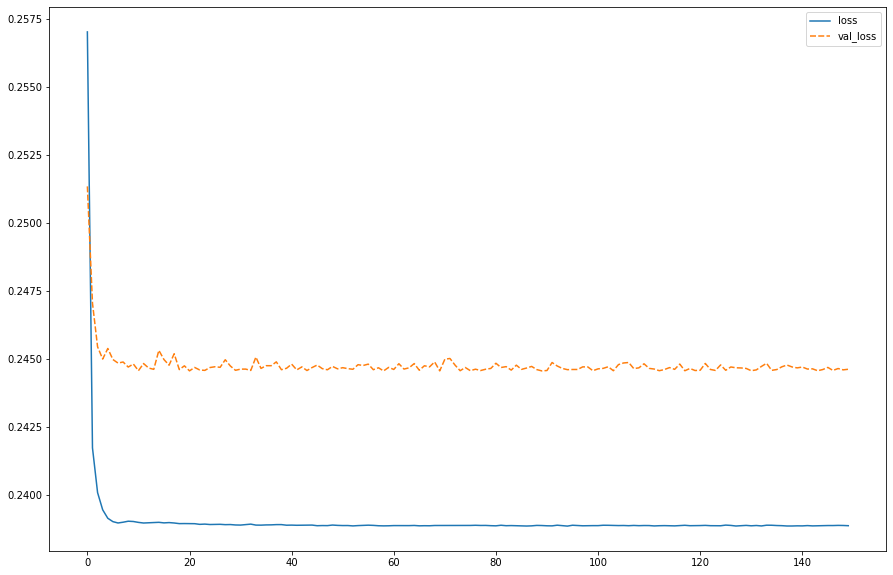

In [101]:
predictions = ann_16.predict(X_test) > .5
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))
sns.lineplot(data=histories["ann_16"].history)

[[3101 4587]
 [ 754 1735]]
              precision    recall  f1-score   support

           0       0.80      0.40      0.54      7688
           1       0.27      0.70      0.39      2489

    accuracy                           0.48     10177
   macro avg       0.54      0.55      0.47     10177
weighted avg       0.67      0.48      0.50     10177



<AxesSubplot:>

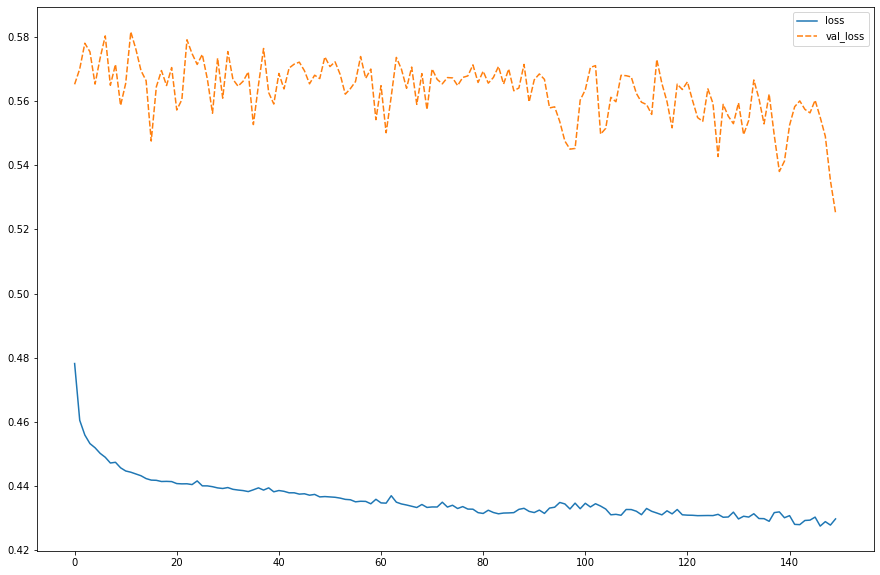

In [102]:
predictions = ann_16_cw.predict(X_test) > .5
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))
sns.lineplot(data=histories["ann_16_cw"].history)